In [1]:
pip install ultralytics opencv-python numpy torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 921.5/921.5 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 24.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [17]:
from google.colab import files

uploaded = files.upload()  # Select a video file to upload
video_path = list(uploaded.keys())[0]  # Get uploaded file name


Saving gettyimages-514539492-640_adpp.mp4 to gettyimages-514539492-640_adpp (1).mp4


In [18]:
import cv2
cap = cv2.VideoCapture(video_path)

fps = cap.get(cv2.CAP_PROP_FPS)
print(f"🎥 Video FPS: {fps}")

cap.release()

🎥 Video FPS: 25.0


In [23]:
from ultralytics import YOLO
import cv2
import torch


# Check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Load YOLOv8 model
model = YOLO("yolov8n.pt")  # 'yolov8x.pt' is the most accurate model


Using device: cuda


In [27]:
import cv2
import pandas as pd
import numpy as np

# Initialize list to store people count and heatmap data
people_count_log = []
heatmap_data = []  # List to store coordinates of detected people


# Open video file
cap = cv2.VideoCapture(video_path)

frame_count = 0  # Counter for processed frames
max_frames = 775  # Set the limit for the number of frames to process

# Get video properties
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Define VideoWriter to save output (detections + heatmap)
output_path = "output_video.mp4"
heatmap_output_path = "heatmap_video.mp4"
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
heatmap_out = cv2.VideoWriter(heatmap_output_path, fourcc, fps, (width, height))

# Set crowd alert threshold
alert_threshold = 30

while cap.isOpened() and frame_count < max_frames:
    ret, frame = cap.read()
    if not ret:
        break

    # Run YOLOv8 detection
    results = model(frame, imgsz=1280, conf=0.4, augment=True)

    people_count = 0
    frame_heatmap_data = []  # Store coordinates for this frame

    for result in results:
        for box in result.boxes:
            if box.cls[0] == 0:  # Class 0 = person
                people_count += 1
                x1, y1, x2, y2 = map(int, box.xyxy[0])  # Get bounding box coordinates
                center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2  # Get center of bounding box
                frame_heatmap_data.append((center_x, center_y))

    # Store heatmap data
    heatmap_data.append(frame_heatmap_data)

    # Append data to list
    people_count_log.append({"Frame": frame_count, "People Count": people_count})

    # Generate heatmap
    heatmap_frame = np.zeros((height, width), dtype=np.uint8)

    for x, y in frame_heatmap_data:
        cv2.circle(heatmap_frame, (x, y), 40, (255), -1)  # Large radius for smooth transition

    heatmap_frame = cv2.GaussianBlur(heatmap_frame, (101, 101), 0)  # Smooth intensity


    # Apply colormap to create heatmap effect
    heatmap_frame = cv2.applyColorMap(heatmap_frame, cv2.COLORMAP_JET)

    # Blend the heatmap with the original frame
    blended_frame = cv2.addWeighted(frame, 0.7, heatmap_frame, 0.3, 0)

    # Annotate frame with detections
    for r in results:
        annotated_frame = r.plot()

    # Overlay heatmap onto the annotated frame
    final_frame = cv2.addWeighted(annotated_frame, 0.7, heatmap_frame, 0.3, 0)

    # Save the processed frames to videos
    out.write(final_frame)  # Save video with detections + heatmap
    heatmap_out.write(heatmap_frame)  # Save only heatmap video

    # Check for crowd alerts
    if people_count > alert_threshold:
        print(f"⚠️ ALERT! High Crowd Detected at Frame {frame_count}: {people_count} people")

    frame_count += 1  # Increment frame count

# Convert to DataFrame and save as CSV
df = pd.DataFrame(people_count_log)
df.to_csv("people_count_log.csv", index=False)

print("People count data saved as 'people_count_log.csv'")

cap.release()
out.release()
heatmap_out.release()
cv2.destroyAllWindows()

print(f"Processed video saved as: {output_path}")
print(f"Heatmap video saved as: {heatmap_output_path}")



0: 736x1280 13 persons, 1 boat, 1 suitcase, 34.9ms
Speed: 6.3ms preprocess, 34.9ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 13 persons, 1 boat, 34.7ms
Speed: 6.5ms preprocess, 34.7ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 16 persons, 34.7ms
Speed: 6.6ms preprocess, 34.7ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 15 persons, 34.6ms
Speed: 7.0ms preprocess, 34.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 17 persons, 34.9ms
Speed: 9.4ms preprocess, 34.9ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 14 persons, 34.8ms
Speed: 6.7ms preprocess, 34.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 15 persons, 34.6ms
Speed: 6.8ms preprocess, 34.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 17 persons, 54.8ms
Speed: 8.9ms preprocess, 54.8m

In [28]:
for result in results:
    people_count = sum(1 for box in result.boxes if box.cls[0] == 0)  # Class 0 is 'person' in COCO dataset
    print(f"People Count: {people_count}")

People Count: 18


In [29]:
import pandas as pd

# Load the logged people count data
df = pd.read_csv("people_count_log.csv")

# Create a "Next Frame People Count" column (Shift values by -1 to predict next frame)
df["Next Frame People Count"] = df["People Count"].shift(-1)

# Drop NaN values (last row will have NaN due to shifting)
df = df.dropna()

print(df.head())  # Check dataset


   Frame  People Count  Next Frame People Count
0      0            13                     13.0
1      1            13                     16.0
2      2            16                     15.0
3      3            15                     17.0
4      4            17                     14.0


In [30]:
!pip install tensorflow


In [61]:
import pandas as pd

# Load the logged people count data
df = pd.read_csv("people_count_log.csv")

# Create a "Next Frame People Count" column (Shift values by -1 to predict next frame)
df["Next Frame People Count"] = df["People Count"].shift(-1)

# Drop NaN values (last row will have NaN due to shifting)
df = df.dropna()

print(df.head())  # Check dataset


   Frame  People Count  Next Frame People Count
0      0            13                     13.0
1      1            13                     16.0
2      2            16                     15.0
3      3            15                     17.0
4      4            17                     14.0


In [59]:
pip install tensorflow keras


In [67]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define parameter grid
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [5, 10, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Grid Search
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring="r2", n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best Model
best_rf = grid_search.best_estimator_
print(f"✅ Best Parameters: {grid_search.best_params_}")


✅ Best Parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


In [113]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Define input (X) and output (y)
X = df[["Frame", "People Count"]]
y = df["Next Frame People Count"]

# Split into training & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)

# Predict future congestion (next frame)
future_frame = pd.DataFrame({"Frame": [df["Frame"].max() + 1], "People Count": [df["People Count"].iloc[-1]]})
predicted_count = rf_model.predict(future_frame)

print(f"🔮 Predicted crowd count for next frame: {predicted_count[0]}")


🔮 Predicted crowd count for next frame: 17.562447808093925


In [114]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Calculate accuracy metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"📊 Model Accuracy Metrics:")
print(f"✅ Mean Absolute Error (MAE): {mae:.2f}")
print(f"✅ Mean Squared Error (MSE): {mse:.2f}")
print(f"✅ Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"✅ R² Score: {r2:.2f} (closer to 1 is better)")


📊 Model Accuracy Metrics:
✅ Mean Absolute Error (MAE): 1.37
✅ Mean Squared Error (MSE): 2.95
✅ Root Mean Squared Error (RMSE): 1.72
✅ R² Score: 0.67 (closer to 1 is better)


In [115]:
future_steps = 10  # Number of future frames to predict
future_frames = []
last_frame = df["Frame"].max()
last_people_count = df["People Count"].iloc[-1]

for _ in range(future_steps):
    future_frame = pd.DataFrame({"Frame": [last_frame + 1], "People Count": [last_people_count]})
    predicted_count = rf_model.predict(future_frame)[0]  # Predict the next frame

    # Store the prediction
    future_frames.append({"Frame": last_frame + 1, "Predicted People Count": predicted_count})

    # Update values for next iteration
    last_frame += 1
    last_people_count = predicted_count

# Convert predictions to DataFrame
future_df = pd.DataFrame(future_frames)
print(future_df)


   Frame  Predicted People Count
0    774               17.562448
1    775               17.756987
2    776               17.756987
3    777               17.756987
4    778               17.756987
5    779               17.756987
6    780               17.756987
7    781               17.756987
8    782               17.756987
9    783               17.756987


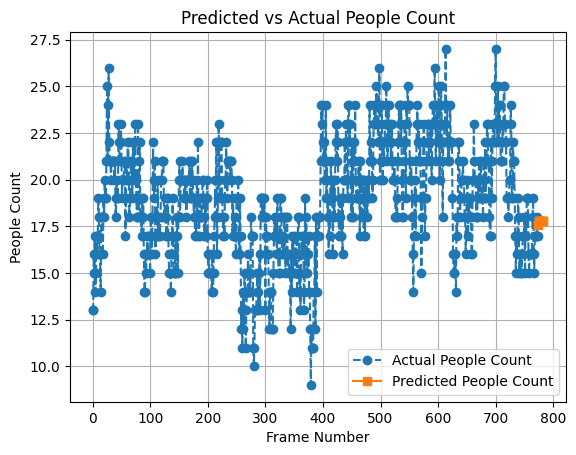

In [116]:
import matplotlib.pyplot as plt

# Plot actual data
plt.plot(df["Frame"], df["People Count"], label="Actual People Count", marker='o', linestyle='dashed')

# Plot predicted data
plt.plot(future_df["Frame"], future_df["Predicted People Count"], label="Predicted People Count", marker='s', linestyle='solid')

plt.xlabel("Frame Number")
plt.ylabel("People Count")
plt.title("Predicted vs Actual People Count")
plt.legend()
plt.grid()
plt.show()


In [117]:
alert_threshold = 30  # Set congestion limit

for index, row in future_df.iterrows():
    if row["Predicted People Count"] > alert_threshold:
        print(f"⚠️ ALERT! High crowd expected at Frame {row['Frame']}: {row['Predicted People Count']} people")

In [118]:
import pandas as pd

# Load dataset
df = pd.read_csv("people_count_log.csv")

# Define a function to allocate staff based on predicted crowd size
def allocate_resources(predicted_crowd):
    if predicted_crowd <= 30:
        return 2  # Minimum staff needed
    elif 30 < predicted_crowd <= 70:
        return 5  # Moderate crowd
    elif 70 < predicted_crowd <= 100:
        return 8  # High crowd
    else:
        return 10  # Maximum deployment for extreme congestion

# Apply the function to create a new "Staff Allocated" column
df["Staff Allocated"] = df["People Count"].apply(allocate_resources)

# Save the modified dataset with staff allocation
df.to_csv("people_count_with_staff.csv", index=False)

# Display the updated dataset
print(df.head())


   Frame  People Count  Staff Allocated
0      0            13                2
1      1            13                2
2      2            16                2
3      3            15                2
4      4            17                2


In [119]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Features (X) → Predicted People Count
X = df[["People Count"]]

# Target (y) → Staff Allocated (Generated)
y = df["Staff Allocated"]

# Split dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42,  min_samples_split=10)
rf_model.fit(X_train, y_train)

print("✅ AI Model for Staff Allocation Trained Successfully!")


✅ AI Model for Staff Allocation Trained Successfully!


In [120]:
# Get future predicted crowd sizes from the dataset
future_predictions = df["People Count"].tolist()

# Predict the required number of staff for each future frame
predicted_staff = rf_model.predict([[x] for x in future_predictions])

# Display AI recommendations
for frame, (crowd, staff) in enumerate(zip(future_predictions, predicted_staff), 1):
    print(f"Frame {frame}: Predicted Crowd = {crowd}, AI-Recommended Staff = {int(staff)}")


Frame 1: Predicted Crowd = 13, AI-Recommended Staff = 2
Frame 2: Predicted Crowd = 13, AI-Recommended Staff = 2
Frame 3: Predicted Crowd = 16, AI-Recommended Staff = 2
Frame 4: Predicted Crowd = 15, AI-Recommended Staff = 2
Frame 5: Predicted Crowd = 17, AI-Recommended Staff = 2
Frame 6: Predicted Crowd = 14, AI-Recommended Staff = 2
Frame 7: Predicted Crowd = 15, AI-Recommended Staff = 2
Frame 8: Predicted Crowd = 17, AI-Recommended Staff = 2
Frame 9: Predicted Crowd = 16, AI-Recommended Staff = 2
Frame 10: Predicted Crowd = 17, AI-Recommended Staff = 2
Frame 11: Predicted Crowd = 19, AI-Recommended Staff = 2
Frame 12: Predicted Crowd = 18, AI-Recommended Staff = 2
Frame 13: Predicted Crowd = 16, AI-Recommended Staff = 2
Frame 14: Predicted Crowd = 16, AI-Recommended Staff = 2
Frame 15: Predicted Crowd = 14, AI-Recommended Staff = 2
Frame 16: Predicted Crowd = 18, AI-Recommended Staff = 2
Frame 17: Predicted Crowd = 18, AI-Recommended Staff = 2
Frame 18: Predicted Crowd = 18, AI-Recom

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [121]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Calculate accuracy metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"📊 Model Accuracy Metrics:")
print(f"✅ Mean Absolute Error (MAE): {mae:.2f}")
print(f"✅ Mean Squared Error (MSE): {mse:.2f}")
print(f"✅ Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"✅ R² Score: {r2:.2f} (closer to 1 is better)")


📊 Model Accuracy Metrics:
✅ Mean Absolute Error (MAE): 0.00
✅ Mean Squared Error (MSE): 0.00
✅ Root Mean Squared Error (RMSE): 0.00
✅ R² Score: 1.00 (closer to 1 is better)


In [122]:
comparison = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})
print(comparison.head(10))  # Show first 10 comparisons


     Actual  Predicted
428       2        2.0
712       2        2.0
326       2        2.0
765       2        2.0
361       2        2.0
541       2        2.0
737       2        2.0
218       2        2.0
120       2        2.0
518       2        2.0


In [ ]:
import smtplib
from email.mime.text import MIMEText

alert_threshold = 30  # Change as needed

# SMTP server configuration
SMTP_SERVER = "smtp.mailersend.net"
SMTP_PORT = 587  # TLS port
SENDER_EMAIL = ""
PASSWORD = ""  # Replace with your actual password
RECEIVER_EMAIL = ""

def send_email_alert(frame, crowd):
    subject = f"🚨 ALERT: High Crowd Expected at Frame {frame}"
    body = f"⚠️ Warning! High crowd of {crowd} people expected.\nPlease allocate extra staff immediately!"

    msg = MIMEText(body)
    msg["Subject"] = subject
    msg["From"] = SENDER_EMAIL
    msg["To"] = RECEIVER_EMAIL

    try:
        server = smtplib.SMTP(SMTP_SERVER, SMTP_PORT)
        server.starttls()
        server.login(SENDER_EMAIL,PASSWORD)
        server.sendmail(SENDER_EMAIL, RECEIVER_EMAIL, msg.as_string())
        server.quit()
        print(f"📧 Email Alert Sent for Frame {frame}!")
    except Exception as e:
        print(f"❌ Failed to send email: {e}")

# Loop through predictions and send email alerts if needed
for frame, crowd in enumerate(future_predictions, 1):
    if crowd > alert_threshold:
        send_email_alert(frame, crowd)
